# Actor-critic

- Value methods: 
    - good for finite set of actions
    - immediate reward signal
- Policy methods: 
    - good for continuous action space
    - reward has to be traced back to the present
        - good final reward may have poor actions along the way

Actor critic combines both with value Critic and policy Actor.


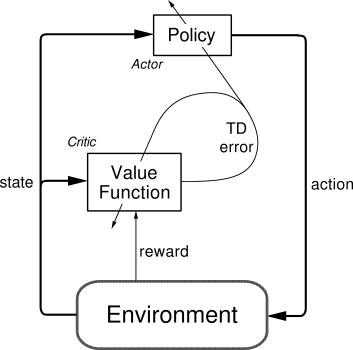 
Sutton

### Notation
| symbol     | meaning           |
|------------|-------------------|
| $\theta$   | policy parameters |
| $w$        | value parameters  |
| $s$        | states            |
| $\pi$      | policy agent      |
| $\alpha$   | learning rate     |
| $\delta_t$ | TD error          |
|            |                   |
|            |                   |




## algorithm
1. Initialize environment and actor/critic parameters
2. Sample action $a$ from $\pi_\theta$
3. For episodes
4. For $t = 1:T$
    1. Get reward $r_t$ and next state $s'$
    2. Get next action $a'$ from $\pi_\theta$
    3. Update policy $\theta \leftarrow \theta + \alpha_\theta Q_w (s, a) \nabla_\theta \ln \pi_\theta(a | s)$
    4. Compute action-value correction (TD error) at $t$:  
        $\delta_t = r_t + \gamma Q_w(s',a') - Q_w(s,a)$
    5. Update $w$ for action-value function:  
        $w \leftarrow w + \alpha_w \delta_t \nabla_w Q_w(s,a)$
    6. Update $a \leftarrow a'$ and $s \leftarrow s'$

- The policy and value function each have their own learning rate $\alpha$
- 


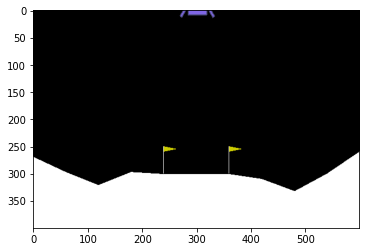

In [1]:

import gym
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from collections import deque
import numpy as np
%matplotlib inline

env = gym.make('LunarLander-v2')
env.reset()
plt.imshow(env.render(mode="rgb_array"));


In [2]:
action_space = env.action_space.n
action_space

4

## Memory

In [3]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    def __len__(self):
        return len(self.buffer)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                 size=batch_size,
                                 replace=False)
        return [self.buffer[i] for i in index]
    def get_all(self):
        return [self.buffer[i] for i in range(len(self.buffer))]

In [4]:
mem = Memory(10)
[mem.add(i) for i in np.arange(10)]
mem.sample(5)
len(mem)

10

In [5]:
MEMORY_SIZE = 600
memory = Memory(max_size=MEMORY_SIZE)

state = env.reset() 

done = False
step_limit = 600
step = 0
while step < step_limit:
    
    random_action = env.action_space.sample()
    new_state, reward, done, info = env.step(random_action)
    
    
    memory.add((state, random_action, new_state, reward, done, info))
    
    if done:
        state = env.reset() 
        
    else:
        state = new_state
        
    step += 1

In [6]:
memory.get_all()[:1]


[(array([ 0.00586805,  1.4104606 ,  0.59434944, -0.0204413 , -0.00679277,
         -0.13462886,  0.        ,  0.        ], dtype=float32),
  2,
  array([ 0.01158009,  1.4105803 ,  0.57872283,  0.00527218, -0.01422094,
         -0.1485771 ,  0.        ,  0.        ], dtype=float32),
  0.5370780022180213,
  False,
  {})]

## Create actor and critic

In [7]:
# choose action from policy given state. pi_theta(a|s)
inputs = layers.Input(shape=(8,))
x = layers.Dense(50, activation="relu")(inputs)
x = layers.Dense(50, activation="relu")(x)
outputs = layers.Dense(4, activation="linear")(x)

actor = tf.keras.Model(inputs, outputs)

print(actor.output_shape)
actor(tf.random.uniform((3,8),-1,1))

(None, 4)


<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 0.24429524, -0.22676496,  0.15699822, -0.28732437],
       [ 0.07451197, -0.09652244,  0.12683451, -0.5366109 ],
       [ 0.4420049 , -0.01867367, -0.23988642, -0.50308466]],
      dtype=float32)>

In [8]:
# predict the Value V_w(s) of each action given the state
# this could also be Q_w(a|s)
inputs = layers.Input(shape=(8,))
x = layers.Dense(50, activation="relu")(inputs)
x = layers.Dense(50, activation="relu")(x)
outputs = layers.Dense(1, activation="linear")(x)

critic = tf.keras.Model(inputs, outputs)

print(critic.output_shape)
critic(tf.random.uniform((3,8),-1,1))

(None, 1)


<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-0.21705371],
       [ 0.06133309],
       [-0.18666649]], dtype=float32)>

In [9]:
def select_action(episode, actor, state):
  
    # get prob of actions
    action_probs = actor(tf.expand_dims(state, axis=0))
    action = tf.random.categorical(action_probs, 1)[0, 0].numpy()
        
    return tf.nn.softmax(action_probs), action

In [10]:
select_action(1, actor, tf.random.normal((8,)))

(<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.42722243, 0.16474953, 0.20544043, 0.2025876 ]], dtype=float32)>,
 2)

# Train

In [11]:
total_episodes = 500       # Total number of training episodes
max_steps = 200               # Max steps per episode

alpha_theta = 0.01          # Learning rate
alpha_w = 0.01
gamma = 0.99                  # Discounting rate

actor_opt = tf.keras.optimizers.Adam(learning_rate=alpha_theta)
critic_opt = tf.keras.optimizers.Adam(learning_rate=alpha_w)

In [12]:
episode_reward_hist = []
actor_loss_hist = []
critic_loss_hist = []

for episode in range(total_episodes):

    step = 0
    state = env.reset()
    done = False
    episode_reward = 0   
    memory = Memory(max_steps)
    
    with tf.GradientTape(persistent=True) as tape:
        
        rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        log_actions = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        Vs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

        
        while not done and step < max_steps:

            step += 1
            action_probs_i, action = select_action(episode, actor, state)
            log_action_i = tf.math.log(tf.squeeze(action_probs_i)[action])
            

            value = critic(tf.expand_dims(state, axis=0))

            new_state, reward, done, info = env.step(action)

#             memory.add((state, action, log_action, value, new_state, reward, done, info))
            rewards = rewards.write(step, reward)
            log_actions = log_actions.write(step, log_action_i)
            values = values.write(step, value)

            state = new_state
            episode_reward += reward
    
        episode_reward_hist.append(episode_reward)
        
        rewards = rewards.stack()
        log_actions = log_actions.stack()
        values = values.stack()
        Vt = tf.constant(0.0) #critic(tf.expand_dims(new_state,0))
        

        replay = memory.get_all()

        # update value estimates
        for t in reversed(range(step+1)):
            Vt = rewards[t] + (gamma * Vt)
            Vs = Vs.write(t, Vt)
        values = tf.squeeze(values)
        Vs = Vs.stack()
        Vs = (Vs - tf.math.reduce_mean(Vs)) / (tf.math.reduce_std(Vs) + 1e-9)
        
        actor_loss = -tf.math.reduce_sum(log_actions * (Vs-values))
        critic_loss = tf.keras.losses.Huber()(values, Vs)
        loss = actor_loss + critic_loss
    
    actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
    critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
    actor_opt.apply_gradients(zip(actor_grads, actor.trainable_variables))
    critic_opt.apply_gradients(zip(critic_grads, critic.trainable_variables))
    
    actor_loss_hist.append(actor_loss)
    critic_loss_hist.append(critic_loss)
    
    if episode % 10 == 0:
        print(f"Episode:{episode}, Loss: {(actor_loss.numpy(), critic_loss.numpy())}, Ep reward:{episode_reward}")



Episode:0, Loss: (28.41275, 0.43317404), Ep reward:-175.32180518140075
Episode:10, Loss: (9.383202, 0.48107192), Ep reward:-114.66623377794706


KeyboardInterrupt: 

In [ ]:
import pandas as pd
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(actor_loss_hist)
plt.grid()
plt.xlabel("Episodes")
plt.ylabel("Actor Loss")

plt.subplot(3,1,2)
plt.plot(critic_loss_hist)
plt.grid()
plt.xlabel("Episodes")
plt.ylabel("Critic Loss")

plt.subplot(3,1,3)
plt.plot(episode_reward_hist)
plt.grid()
plt.xlabel("Episodes")
plt.ylabel("Episode Reward")
plt.tight_layout()
plt.show()

In [ ]:
# Render an episode and save as a GIF file
from matplotlib import animation , rc
%matplotlib inline
fig = plt.figure()
images = []

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 

    state = tf.constant(env.reset(), dtype=tf.float32)
    for i in range(1, max_steps + 1):
        state = tf.expand_dims(state, 0)
        action_probs = model(state)
        action = np.argmax(np.squeeze(action_probs))

        state, _, done, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)

        # Render screen every 10 steps
        if i % 5 == 0:
            screen = plt.imshow(env.render(mode='rgb_array'))
            images.append([screen])

        if done:
            break

    return images


# Save GIF image
images = render_episode(env, actor, 500)
image_file = 'lunarLander.gif'


an = animation.ArtistAnimation(fig, images, interval=100, repeat_delay=1000, blit=True)
rc('animation', html='jshtml')
an

In [ ]:
f = r"animation.gif" 
writergif = animation.PillowWriter(fps=30) 
an.save(f, writer=writergif)